In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import pandas as pd 
import scipy.stats as stats 

from scipy.stats.mstats import winsorize
from scipy.stats import jarque_bera # New in this Thinkful module
from scipy.stats import normaltest # New in this Thinkful module
from scipy.stats import boxcox # New in this Thinkful module
from scipy.stats import skew
from sklearn.preprocessing import normalize # New in this Thinkful module
from sklearn.preprocessing import scale # New in this Thinkful module
from sqlalchemy import create_engine 
from sqlalchemy.engine.url import URL 

import warnings 

warnings.filterwarnings("ignore")
plt.style.use("default")
sns.set(style="whitegrid")

In [ ]:
kagle = dict(
    drivername="postgresql", 
    username="dsbc_student", 
    password="7*.8G9QH21", 
    host="142.93.121.174", 
    port="5432", 
    database="youtube"
)

engine = create_engine(URL(**kagle), echo=True)

youtube_df = pd.read_sql_query("SELECT * FROM youtube", con=engine)

engine.dispose()

In [ ]:
# Deal with the missing values
youtube_df["Video Uploads"] = youtube_df["Video Uploads"].apply(str.strip).replace("--", np.nan)
youtube_df["Video Uploads"] = pd.to_numeric(youtube_df["Video Uploads"], downcast="float")

youtube_df["Subscribers"] = youtube_df["Subscribers"].apply(str.strip).replace("--", np.nan)
youtube_df["Subscribers"] = pd.to_numeric(youtube_df["Subscribers"], downcast="float")

youtube_df["Grade"] = youtube_df["Grade"].apply(str.strip).replace("",np.nan)

youtube_df["Video Uploads"].fillna(youtube_df["Video Uploads"].mean(), inplace=True)
youtube_df["Subscribers"].fillna(youtube_df["Subscribers"].mean(), inplace=True)

In [ ]:
"""
    Apply a one-way winsorization to the highest end of the value distribution.  There are a lot of extreme values, so set the value of the outliers to the values of the 90th percentile.
"""
youtube_df["winsorized_uploads"] = winsorize(youtube_df["Video Uploads"], (0, 0.10))
youtube_df["winsorized_subscribers"] = winsorize(youtube_df["Subscribers"], (0, 0.10))
youtube_df["winsorized_views"] = winsorize(youtube_df["Video views"], (0, 0.10))

for i in range(0,len(youtube_df["Grade"])):
    if pd.isnull(youtube_df["Grade"][i]):
        youtube_df["Grade"][i] = youtube_df["Grade"][i-1]

### _Working with categrorical values_

In [ ]:
"""
    Since most models require that all data be numeric, you need to convert string based categorical data to use it.  One method is called 'one hot-encoding'.  In one hot-encoding', to get the information from a categorical variable with X levels, create X-1 numeric features, each of which is coded 1 or 0.  The resulting variables are known as dummy or indicator varialbes.
"""
pd.get_dummies(youtube_df["Grade"], drop_first=False)

In [ ]:
# Concat the indicator variables to the youtube_df
youtube_df = pd.concat([youtube_df, pd.get_dummies(youtube_df["Grade"])], axis=1)
youtube_df

### _Dealing with non-normality_

In [ ]:
"""
    Many machine learning models assume the target variable to be normally distributed.  Non-normal variables can sometimes be transformed into normally distributed features using transformations such at taking the square root, the inverse, or the log of the variable; or by applying the Box-Cox transformation
"""
# histograms of the original data
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.hist(youtube_df["Subscribers"])
plt.title("Histogram of Subscribers")

plt.subplot(1,3,2)
plt.hist(youtube_df["Video Uploads"])
plt.title("Histogram of Video Uploads")

plt.subplot(1,3,3)
plt.hist(youtube_df["Video views"])
plt.title("Histogram of Video Views")

plt.suptitle("Histograms of Origional Data")

# Histograms of winsorized data
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.hist(youtube_df["winsorized_subscribers"])
plt.title("Histogram of Winsorized Subscribers")
plt.xticks(rotation=90)

plt.subplot(1,3,2)
plt.hist(youtube_df["winsorized_uploads"])
plt.title("Histogram of Winsorized Uploads")

plt.subplot(1,3,3)
plt.hist(youtube_df["winsorized_views"])
plt.title("Histogram of Winsorized Views")

plt.suptitle("Histograms of Winsorized Data")

# Histograms of Log transformed data
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.hist(np.log(youtube_df["Subscribers"]))
plt.title("Histogram of Log Tranformed Subscribers")

plt.subplot(1,3,2)
plt.hist(np.log(youtube_df["Video Uploads"]))
plt.title("Histogram of Log Transformed Uploads")

plt.subplot(1,3,3)
plt.hist(np.log(youtube_df["Video views"]))
plt.title("Histogram of Log Transformed Views")

plt.suptitle("Histograms of Log Transformed Data")

plt.show()

"""
    As illustrated below, taking the logs of the three variables transformed their distributions so that they more colosely resemble the normal distribution.  Though they are not exactly normally distributed.
"""

In [ ]:
"""
    You can statistically verify the distributions of the log transformed variables still don't follow the normal distribution by using the Jarque-Bera and Normal tests from scipy
"""
jb_stats = jarque_bera(np.log(youtube_df["Subscribers"]))
normal_stats = normaltest(np.log(youtube_df["Subscribers"]))

print("Stats for Subscribers:")
print(f"Jarque-Bera test statistic is {jb_stats[0]} and p-value is {jb_stats[1]}")
print(f"Normality test statistic is {normal_stats[0]} and p-value is {normal_stats[0]}")

jb_stats = jarque_bera(np.log(youtube_df["Video Uploads"]))
normal_stats = normaltest(np.log(youtube_df["Video Uploads"]))

print(f"\nStats for Video Uploads:")
print(f"Jarque-Bera test statistic is {jb_stats[0]} and p-value is {jb_stats[1]}")
print(f"Normality test statistic is {normal_stats[0]} and p-value is {normal_stats[0]}")

jb_stats = jarque_bera(np.log(youtube_df["Video views"]))
normal_stats = normaltest(np.log(youtube_df["Video views"]))

print(f"\nStats for Video Views:")
print(f"Jarque-Bera test statistic is {jb_stats[0]} and p-value is {jb_stats[1]}")
print(f"Normality test statistic is {normal_stats[0]} and p-value is {normal_stats[0]}")

In [ ]:
"""
    Another common method to make varibles normally distributed is the Box-Cox transformation.  This can be achieved using SciPy's boxcox() function.  Box-Cox, Log, and Square Root transformations only work when all datapoints are positive
"""
subscribers_boxcox,_ = boxcox(youtube_df["Subscribers"])
video_uploads_boxcox,_ = boxcox(youtube_df["Video Uploads"])
video_views_boxcox,_ = boxcox(youtube_df["Video views"])

plt.figure(figsize=(18,5))

# Histograms of the box-cox transformed data
plt.subplot(1,3,1)
plt.hist(subscribers_boxcox)
plt.title("Histogram of Subscribers (Box-Cox transformed)")

plt.subplot(1,3,2)
plt.hist(video_uploads_boxcox)
plt.title("Histogram of Video Uploads (Box-Cox transformed)")

plt.subplot(1,3,3)
plt.hist(video_views_boxcox)
plt.title("Histogram of Video Views (Box-Cox transformed)")

plt.suptitle("Box-Cox transformations")

plt.show();


In [ ]:
jb_stats = jarque_bera(subscribers_boxcox)
normal_stats = normaltest(subscribers_boxcox)

print("Stats for Subscribers:")
print(f"Jarque-Bera test statistic is {jb_stats[0]} and p-value is {jb_stats[1]}")
print(f"Normality test statistic is {normal_stats[0]} and p-value is {normal_stats[0]}")

jb_stats = jarque_bera(video_uploads_boxcox)
normal_stats = normaltest(video_uploads_boxcox)

print(f"\nStats for Video Uploads:")
print(f"Jarque-Bera test statistic is {jb_stats[0]} and p-value is {jb_stats[1]}")
print(f"Normality test statistic is {normal_stats[0]} and p-value is {normal_stats[0]}")

jb_stats = jarque_bera(video_views_boxcox)
normal_stats = normaltest(video_views_boxcox)

print(f"\nStats for Video Views:")
print(f"Jarque-Bera test statistic is {jb_stats[0]} and p-value is {jb_stats[1]}")
print(f"Normality test statistic is {normal_stats[0]} and p-value is {normal_stats[0]}")

### _Normalization and Standardization_

_Normalization_ rescales a variable into the \[0,1\] range (including 0 and 1).  You will use SKLearn's ```processing.normalize()``` function to achieve this. 

_Standardization_ rescales a variable so it's _mean_ becomes 0 and its _standard deviation_ becomes 1.  _Standardization_ does not a apply  a maximum value for the variable.  Use SKLean's ```preprocessing.scale()``` module.

In [ ]:
# Normalize the winsorized variables
youtube_df["norm_winsorized_subscribers"] = normalize(np.array(youtube_df["winsorized_subscribers"]).reshape(1,-1)).reshape(-1,1)
youtube_df["norm_winsorized_views"] = normalize(np.array(youtube_df["winsorized_views"]).reshape(1,-1)).reshape(-1,1)
youtube_df["norm_winsorized_uploads"] = normalize(np.array(youtube_df["winsorized_uploads"]).reshape(1,-1)).reshape(-1,1)

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.scatter(youtube_df["winsorized_subscribers"], youtube_df["norm_winsorized_subscribers"])
plt.title("Scatterplot of original and normalized values (Subscribers)")
plt.xlabel("Winsorized value")
plt.ylabel("Winsorized value (normalized)")

plt.subplot(1,3,2)
plt.scatter(youtube_df["winsorized_views"], youtube_df["norm_winsorized_views"])
plt.title("Scatter plot of original and normalized values (Views)")
plt.xlabel("Winsorized value")
plt.ylabel("Winsorized value (normalized)")

plt.subplot(1,3,3)
plt.scatter(youtube_df["winsorized_uploads"], youtube_df["norm_winsorized_uploads"])
plt.title("Scatter plot of original and normalized values (uploads)")
plt.xlabel("Winsorized value")
plt.ylabel("Winsorized value (normalized)")

plt.show();

In [ ]:
# This time Standardize the winsorized values
youtube_df["scaled_winsorized_subscribers"] = scale(youtube_df["winsorized_subscribers"])
youtube_df["scaled_winsorized_views"] = scale(youtube_df["winsorized_views"])
youtube_df["scaled_winsorized_uploads"] = scale(youtube_df["winsorized_uploads"])

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.scatter(youtube_df["winsorized_subscribers"], youtube_df["scaled_winsorized_subscribers"])
plt.title("Scatterplot of original and standardized values (Subscribers)")
plt.xlabel("Winsorized value")
plt.ylabel("Winsorized value (Standardized)")
plt.xlim(0.00000001)

plt.subplot(1,3,2)
plt.scatter(youtube_df["winsorized_views"], youtube_df["scaled_winsorized_views"])
plt.title("Scatterplot of original and standardized values (Views)")
plt.xlabel("Winsorized value")
plt.ylabel("Winsorized value (Standardized)")

plt.subplot(1,3,3)
plt.scatter(youtube_df["winsorized_uploads"], youtube_df["scaled_winsorized_uploads"])
plt.title("Scatterplot of original and standardized values (Uploads)")
plt.xlabel("Winsorized value")
plt.ylabel("Winsorized value (Standardized)")

plt.show();

## _Assignment_

In [178]:
kagle2 = dict(
    drivername="postgresql", 
    username="dsbc_student", 
    password="7*.8G9QH21", 
    host="142.93.121.174", 
    port="5432", 
    database="studentsperformance"
)

engine=create_engine(URL(**kagle2), echo=True)

student_df = pd.read_sql_query("SELECT * FROM studentsperformance", con=engine)

engine.dispose()

2019-11-25 21:22:41,929 INFO sqlalchemy.engine.base.Engine select version()
2019-11-25 21:22:41,943 INFO sqlalchemy.engine.base.Engine {}
2019-11-25 21:22:42,064 INFO sqlalchemy.engine.base.Engine select current_schema()
2019-11-25 21:22:42,067 INFO sqlalchemy.engine.base.Engine {}
2019-11-25 21:22:42,185 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-11-25 21:22:42,189 INFO sqlalchemy.engine.base.Engine {}
2019-11-25 21:22:42,245 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-11-25 21:22:42,249 INFO sqlalchemy.engine.base.Engine {}
2019-11-25 21:22:42,299 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2019-11-25 21:22:42,302 INFO sqlalchemy.engine.base.Engine {}
2019-11-25 21:22:42,428 INFO sqlalchemy.engine.base.Engine SELECT * FROM studentsperformance
2019-11-25 21:22:42,431 INFO sqlalchemy.engine.base.Engine {}


### _1. Are the exam score variables normally distributed? If not, apply a Box-Cox transformation. Does anything change?_

In [179]:
# Print a list of column headers 
print(*(x for x in student_df.columns), sep="\n")

gender
race/ethnicity
parental level of education
lunch
test preparation course
math score
reading score
writing score


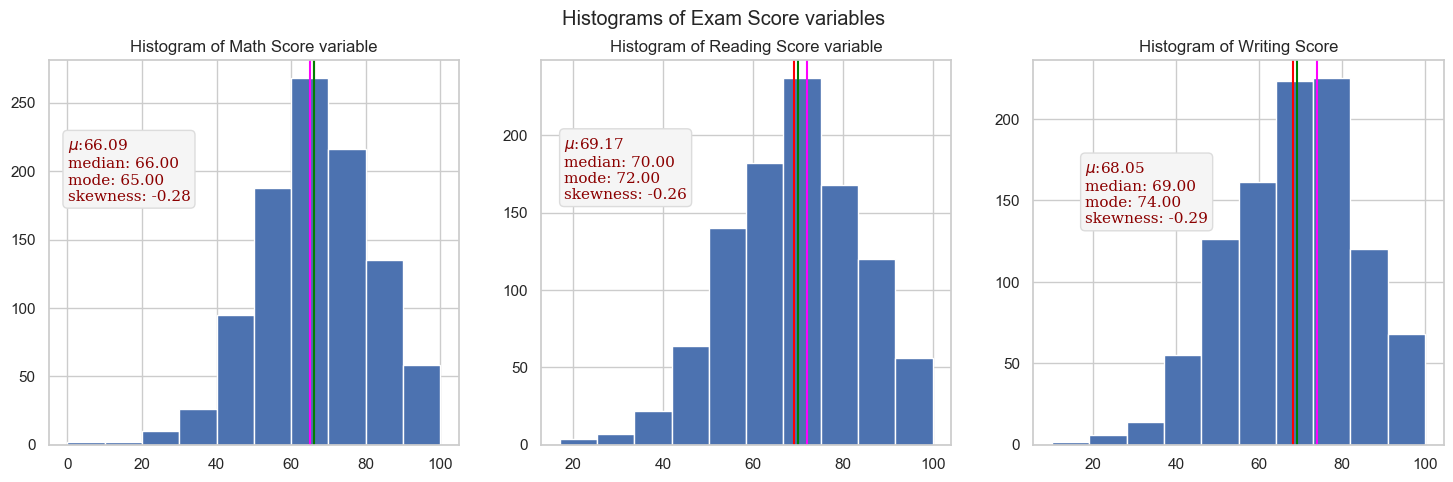

In [180]:
# Plot histograms to show distributions for the "math score", "reading score", and "writing score" variables
text_box = dict(boxstyle="round",ec="gainsboro",fc="whitesmoke")
font = dict(family="serif",color="darkred",weight="normal",size=11)

plt.figure(figsize=(18,5))

# Math Score variable
plt.subplot(1,3,1)
plt.hist(student_df["math score"]) 
plt.title("Histogram of Math Score variable")

math_mean = student_df["math score"].mean()
math_median = student_df["math score"].median()
math_mode = student_df["math score"].mode()
math_skew = student_df["math score"].skew()

plt.axvline(x=math_mean, color="red")
plt.axvline(x=math_median, color="green")
plt.axvline(x=math_mode[0], color="magenta")

textstr = f"$ \mu $:{math_mean:,.2f} \nmedian: {math_median:,.2f} \nmode: {math_mode[0]:,.2f} \nskewness: {math_skew:,.2f}"
plt.text(0.05,225,textstr,verticalalignment="top",fontdict=font,bbox=text_box)

# Reading Score variable
plt.subplot(1,3,2)
plt.hist(student_df["reading score"])
plt.title("Histogram of Reading Score variable")

reading_mean = student_df["reading score"].mean()
reading_median = student_df["reading score"].median()
reading_mode = student_df["reading score"].mode()
reading_skew = student_df["reading score"].skew()

plt.axvline(x=reading_mean, color="red")
plt.axvline(x=reading_median, color="green")
plt.axvline(x=reading_mode[0], color="magenta")

textstr = f"$ \mu $:{reading_mean:,.2f} \nmedian: {reading_median:,.2f} \nmode: {reading_mode[0]:,.2f} \nskewness: {reading_skew:,.2f}"
plt.text(18,200,textstr,verticalalignment="top",fontdict=font,bbox=text_box)

# Writing Score variable
plt.subplot(1,3,3)
plt.hist(student_df["writing score"])
plt.title("Histogram of Writing Score")

writing_mean = student_df["writing score"].mean()
writing_median = student_df["writing score"].median()
writing_mode = student_df["writing score"].mode()
writing_skew = student_df["writing score"].skew()

plt.axvline(x=writing_mean, color="red")
plt.axvline(x=writing_median, color="green")
plt.axvline(x=writing_mode[0], color="magenta")

textstr = f"$ \mu $:{writing_mean:,.2f} \nmedian: {writing_median:,.2f} \nmode: {writing_mode[0]:,.2f} \nskewness: {writing_skew:,.2f}"
plt.text(18,175,textstr,verticalalignment="top",fontdict=font,bbox=text_box)

plt.suptitle("Histograms of Exam Score variables")

plt.show();

The three exam score variables exhibit some skewness.  The Math Score is slightly negatively skewed at -0.28.  The Reading Score variable has a slight negative skew at -0.17.  Finally, the Writing Score variable has a slight negative skew at -0.19.

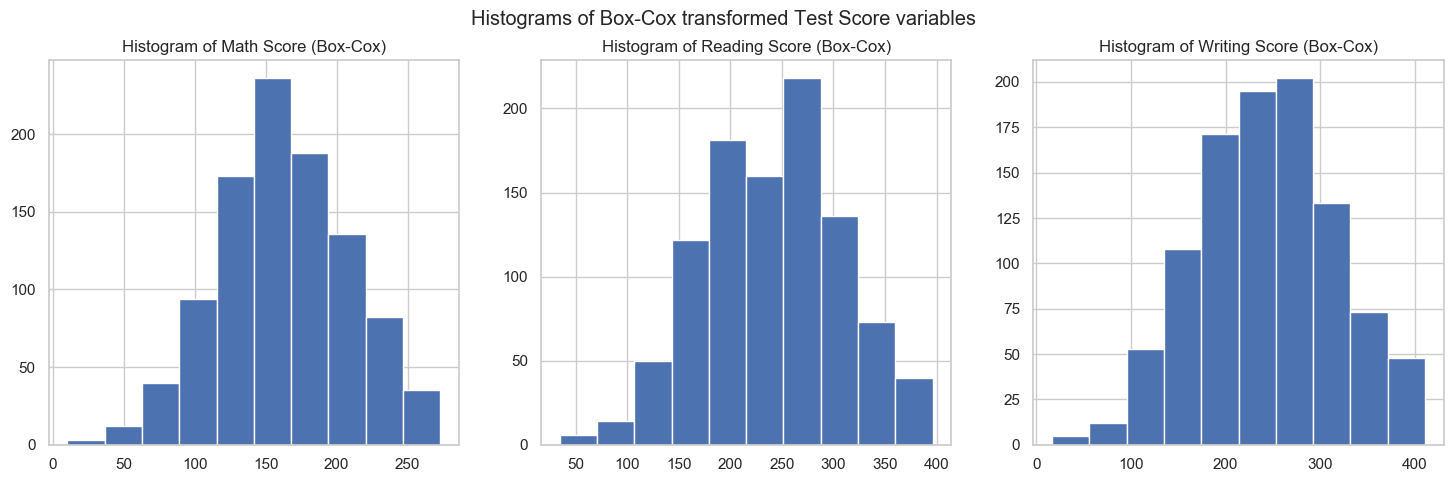

In [181]:
# Apply a Box-Cox transformation and compare
# The Box-Cox transformation will only work with positive numbers > 0.  There is an observation = 0, dropping
math_score_boxcox,_ = boxcox(student_df[student_df["math score"]>0]["math score"]) 
reading_score_boxcox,_ = boxcox(student_df["reading score"])
writing_score_boxcox,_ = boxcox(student_df["writing score"])

plt.figure(figsize=(18,5))

# Math Score Box-Cox
plt.subplot(1,3,1)
plt.hist(math_score_boxcox)
plt.title("Histogram of Math Score (Box-Cox)")

# Reading Score Box-Cox
plt.subplot(1,3,2)
plt.hist(reading_score_boxcox)
plt.title("Histogram of Reading Score (Box-Cox)")

# Writing Score Box-Cox
plt.subplot(1,3,3)
plt.hist(writing_score_boxcox)
plt.title("Histogram of Writing Score (Box-Cox)")

plt.suptitle("Histograms of Box-Cox transformed Test Score variables")

plt.show();

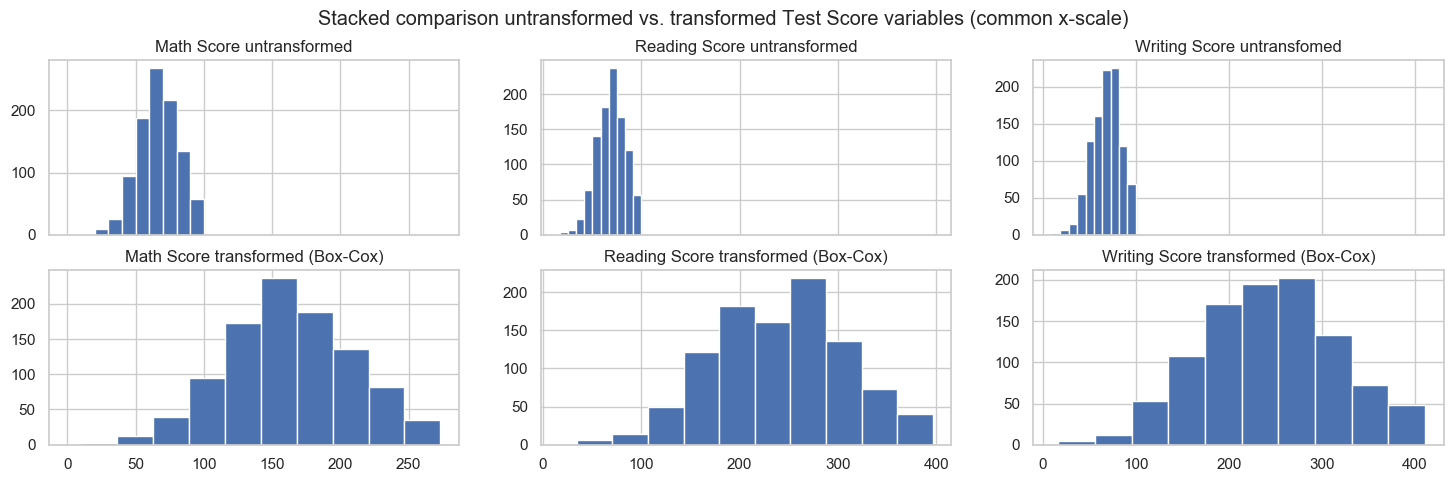

In [182]:
fig, axs = plt.subplots(2,3, figsize=(18,5), sharex="col", sharey=False)
# Math Score variable
axs[0,0].hist(student_df["math score"])
axs[0,0].set_title("Math Score untransformed")
axs[1,0].hist(math_score_boxcox)
axs[1,0].set_title("Math Score transformed (Box-Cox)")

# Reading Score variable
axs[0,1].hist(student_df["reading score"])
axs[0,1].set_title("Reading Score untransformed")
axs[1,1].hist(reading_score_boxcox)
axs[1,1].set_title("Reading Score transformed (Box-Cox)")

# Writig Score variable
axs[0,2].hist(student_df["writing score"])
axs[0,2].set_title("Writing Score untransfomed")
axs[1,2].hist(writing_score_boxcox)
axs[1,2].set_title("Writing Score transformed (Box-Cox)")

plt.suptitle("Stacked comparison untransformed vs. transformed Test Score variables (common x-scale)")

plt.show();

In [183]:
# Compare the distributions for the untransformed variables vs. the Box-Cox transformed variables
# Math Score variable
untransformed_jb_stats_math = jarque_bera(student_df["math score"])
untransformed_normal_math = normaltest(student_df["math score"])
untransformed_skew_math = student_df["math score"].skew()
transformed_jb_stats_math = jarque_bera(math_score_boxcox)
transformed_normal_math = normaltest(math_score_boxcox)
transformed_skew_math = skew(math_score_boxcox)

# Reading Score variable
untransformed_jb_stats_reading = jarque_bera(student_df["reading score"])
untransformed_normal_reading = normaltest(student_df["reading score"])
untransformed_skew_reading = student_df["reading score"].skew()
transformed_jb_stats_reading = jarque_bera(reading_score_boxcox)
transformed_normal_reading = normaltest(reading_score_boxcox)
transformed_skew_reading = skew(reading_score_boxcox)

# Writing Score variable
untransformed_jb_stats_writing = jarque_bera(student_df["writing score"])
untransformed_normal_writing = normaltest(student_df["writing score"])
untransformed_skew_writing = student_df["writing score"].skew()
transformed_jb_stats_writing = jarque_bera(writing_score_boxcox)
transformed_normal_writing = normaltest(writing_score_boxcox)
transformed_skew_writing = skew(writing_score_boxcox)

print("Stats for untransfomed Math Score variable:")
print(f"\t{'Jarque-Bera':<{14}}: {untransformed_jb_stats_math[0]:>{10},.6f} | "
    f"{'p-value'}: {untransformed_jb_stats_math[1]:>{10},.6f}")
print(f"\t{'Normality test':<{14}}: {untransformed_normal_math[0]:>{10},.6f} | "
    f"{'p-value'}: {untransformed_normal_math[1]:>{10},.6f}")
print(f"\t{'Skewness':<{14}}: {untransformed_skew_math:>{10},.6f}")
print(f"\t"+"-"*75)
print(f"\t{'Jarque-Bera':<{14}}: {transformed_jb_stats_math[0]:>{10},.6f} | "
    f"{'p-value'}: {transformed_jb_stats_math[1]:>{10},.6f}")
print(f"\t{'Normality test':<{14}}: {transformed_normal_math[0]:>{10},.6f} | "
    f"{'p-value'}: {transformed_normal_math[1]:>{10},.6f}")
print(f"\t{'Skewness':<{14}}: {transformed_skew_math:>{10},.6f}")

print("\nStats for untransfomed Reading Score variable:")
print(f"\t{'Jarque-Bera':<{14}}: {untransformed_jb_stats_reading[0]:>{10},.6f} | "
    f"{'p-value'}: {untransformed_jb_stats_reading[1]:>{10},.6f}")
print(f"\t{'Normality test':<{14}}: {untransformed_normal_reading[0]:>{10},.6f} | "
    f"{'p-value'}: {untransformed_normal_reading[1]:>{10},.6f}")
print(f"\t{'Skewness':<{14}}: {untransformed_skew_reading:>{10},.6f}")
print(f"\t"+"-"*75)
print(f"\t{'Jarque-Bera':<{14}}: {transformed_jb_stats_reading[0]:>{10},.6f} | "
    f"{'p-value'}: {transformed_jb_stats_reading[1]:>{10},.6f}")
print(f"\t{'Normality test':<{14}}: {transformed_normal_reading[0]:>{10},.6f} | "
    f"{'p-value'}: {transformed_normal_reading[1]:>{10},.6f}")
print(f"\t{'Skewness':<{14}}: {transformed_skew_reading:>{10},.6f}")

print("\nStats for untransfomed Writing Score variable:")
print(f"\t{'Jarque-Bera':<{14}}: {untransformed_jb_stats_writing[0]:>{10},.6f} | "
    f"{'p-value'}: {untransformed_jb_stats_writing[1]:>{10},.6f}")
print(f"\t{'Normality test':<{14}}: {untransformed_normal_writing[0]:>{10},.6f} | "
    f"{'p-value'}: {untransformed_normal_writing[1]:>{10},.6f}")
print(f"\t{'Skewness':<{14}}: {untransformed_skew_writing:>{10},.6f}")
print(f"\t"+"-"*75)
print(f"\t{'Jarque-Bera':<{14}}: {transformed_jb_stats_writing[0]:>{10},.6f} | "
    f"{'p-value'}: {transformed_jb_stats_writing[1]:>{10},.6f}")
print(f"\t{'Normality test':<{14}}: {transformed_normal_writing[0]:>{10},.6f} | "
    f"{'p-value'}: {transformed_normal_writing[1]:>{10},.6f}")
print(f"\t{'Skewness':<{14}}: {transformed_skew_writing:>{10},.6f}")

Stats for untransfomed Math Score variable:
	Jarque-Bera   :  15.912257 | p-value:   0.000351
	Normality test:  15.408961 | p-value:   0.000451
	Skewness      :  -0.278935
	---------------------------------------------------------------------------
	Jarque-Bera   :   1.720098 | p-value:   0.423141
	Normality test:   1.832308 | p-value:   0.400055
	Skewness      :  -0.018496

Stats for untransfomed Reading Score variable:
	Jarque-Bera   :  11.383301 | p-value:   0.003374
	Normality test:  11.117413 | p-value:   0.003854
	Skewness      :  -0.259105
	---------------------------------------------------------------------------
	Jarque-Bera   :   4.119779 | p-value:   0.127468
	Normality test:   5.282275 | p-value:   0.071280
	Skewness      :  -0.031815

Stats for untransfomed Writing Score variable:
	Jarque-Bera   :  13.985094 | p-value:   0.000919
	Normality test:  13.606451 | p-value:   0.001110
	Skewness      :  -0.289444
	-----------------------------------------------------------------

### _2. Say we want to use a single variable for the exam scores as our target. For this purpose, create a new variable by taking a weighted average of the exam scores. Check whether this new variable is normally distributed. If it's not normally distributed, apply a Box-Cox transformation and check whether or not the transformed variable is normally distributed._

In [184]:
# Question disambiguation: Cannot create a weighted average as there are no weights
student_df["avg_score"] = (student_df["math score"] + student_df["reading score"] + student_df["writing score"])/3

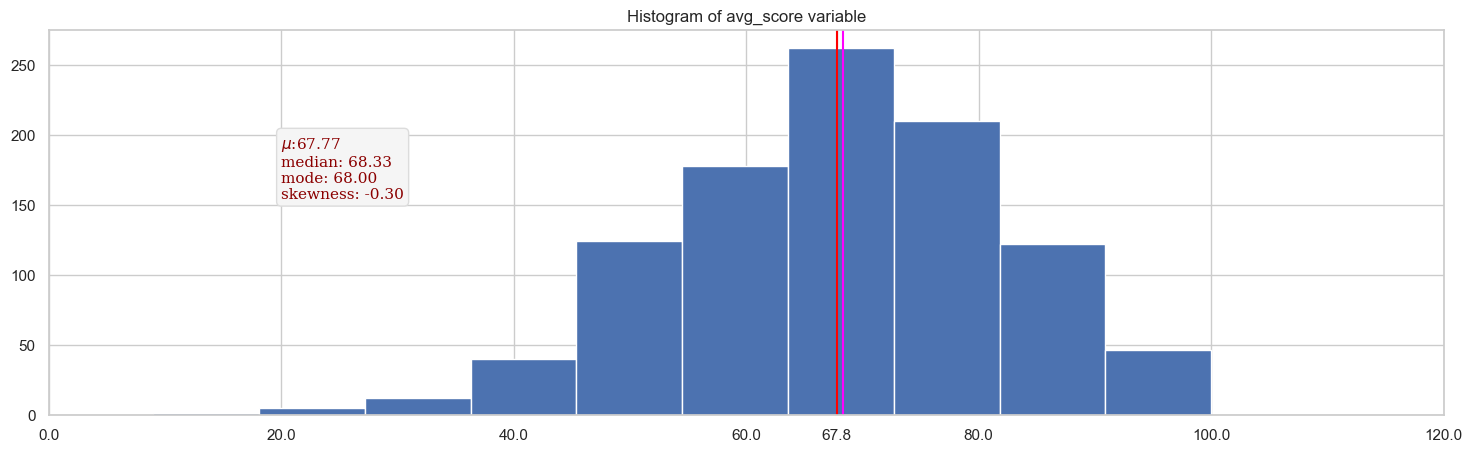

In [185]:
# Take a look at the distribution of the avg_score variable
plt.figure(figsize=(18,5))

plt.hist(student_df["avg_score"])
plt.title("Histogram of avg_score variable")

avg_score_mean = student_df["avg_score"].mean()
avg_score_median = student_df["avg_score"].median()
avg_score_mode = student_df["avg_score"].mode()
avg_score_skew = student_df["avg_score"].skew()

plt.axvline(x=avg_score_mean, color="red")
plt.axvline(x=avg_score_median, color="magenta")

extraticks = [avg_score_mean]
plt.xticks(list(plt.xticks()[0])+extraticks)

textstr = f"$ \mu $:{avg_score_mean:,.2f} \nmedian: {avg_score_median:,.2f} \nmode: {avg_score_mode[0]:,.2f} \nskewness: {avg_score_skew:,.2f}"
plt.text(20,200,textstr,verticalalignment="top",fontdict=font,bbox=text_box)

plt.show();

In [186]:
untransformed_jb_stats_avg_score = jarque_bera(student_df["avg_score"])
untransformed_normal_avg_score = normaltest(student_df["avg_score"])
untransformed_skew_avg_score = student_df["avg_score"].skew()

print("Stats for untransfomed Math Score variable:")
print(f"\t{'Jarque-Bera':<{14}}: {untransformed_jb_stats_avg_score[0]:>{10},.6f} | "
    f"{'p-value'}: {untransformed_jb_stats_avg_score[1]:>{10},.6f}")
print(f"\t{'Normality test':<{14}}: {untransformed_normal_avg_score[0]:>{10},.6f} | "
    f"{'p-value'}: {untransformed_normal_avg_score[1]:>{10},.6f}")
print(f"\t{'Skewness':<{14}}: {untransformed_skew_avg_score:>{10},.6f}")

Stats for untransfomed Math Score variable:
	Jarque-Bera   :  15.453388 | p-value:   0.000441
	Normality test:  15.186721 | p-value:   0.000504
	Skewness      :  -0.299057


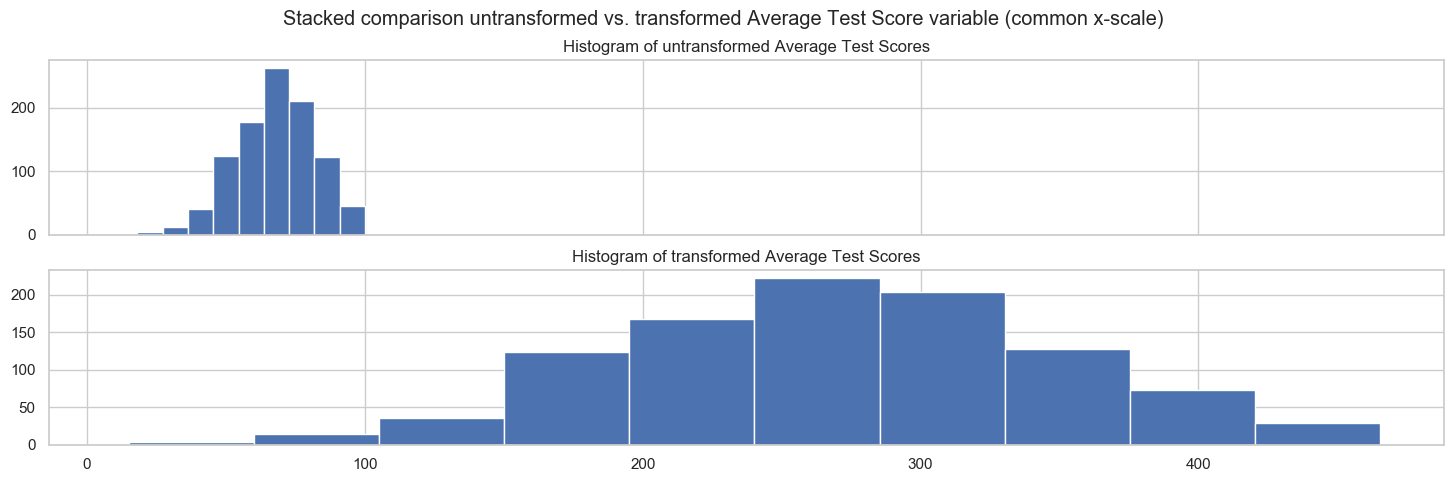

In [187]:
# Apply a Box-Cox Transformation to the avg_score varialbe
avg_score_boxcox,_ = boxcox(student_df["avg_score"]) 

fig, axs = plt.subplots(2,1, figsize=(18,5), sharex="col", sharey=False)

axs[0].hist(student_df["avg_score"])
axs[0].set_title("Histogram of untransformed Average Test Scores")

axs[1].hist(avg_score_boxcox)
axs[1].set_title("Histogram of transformed Average Test Scores")

plt.suptitle("Stacked comparison untransformed vs. transformed Average Test Score variable (common x-scale)")

plt.show();

In [188]:
transformed_jb_stats_avg = jarque_bera(avg_score_boxcox)
transformed_normal_avg = normaltest(avg_score_boxcox)
transformed_skew_avg = skew(avg_score_boxcox)

print("Stats for transfomed Average Score variable:")
print(f"\t{'Jarque-Bera':<{14}}: {transformed_jb_stats_avg[0]:>{10},.6f} | "
    f"{'p-value'}: {transformed_jb_stats_avg[1]:>{10},.6f}")
print(f"\t{'Normality test':<{14}}: {transformed_normal_avg[0]:>{10},.6f} | "
    f"{'p-value'}: {transformed_normal_avg[1]:>{10},.6f}")
print(f"\t{'Skewness':<{14}}: {transformed_skew_avg:>{10},.6f}")

Stats for transfomed Average Score variable:
	Jarque-Bera   :   2.435399 | p-value:   0.295910
	Normality test:   2.779858 | p-value:   0.249093
	Skewness      :  -0.023945


### _3. Which variables seem related to the target variable (the newly created variable in the previous question)? If our goal is to explain the determinants of success in exams, which variables in our dataset might be useful?_

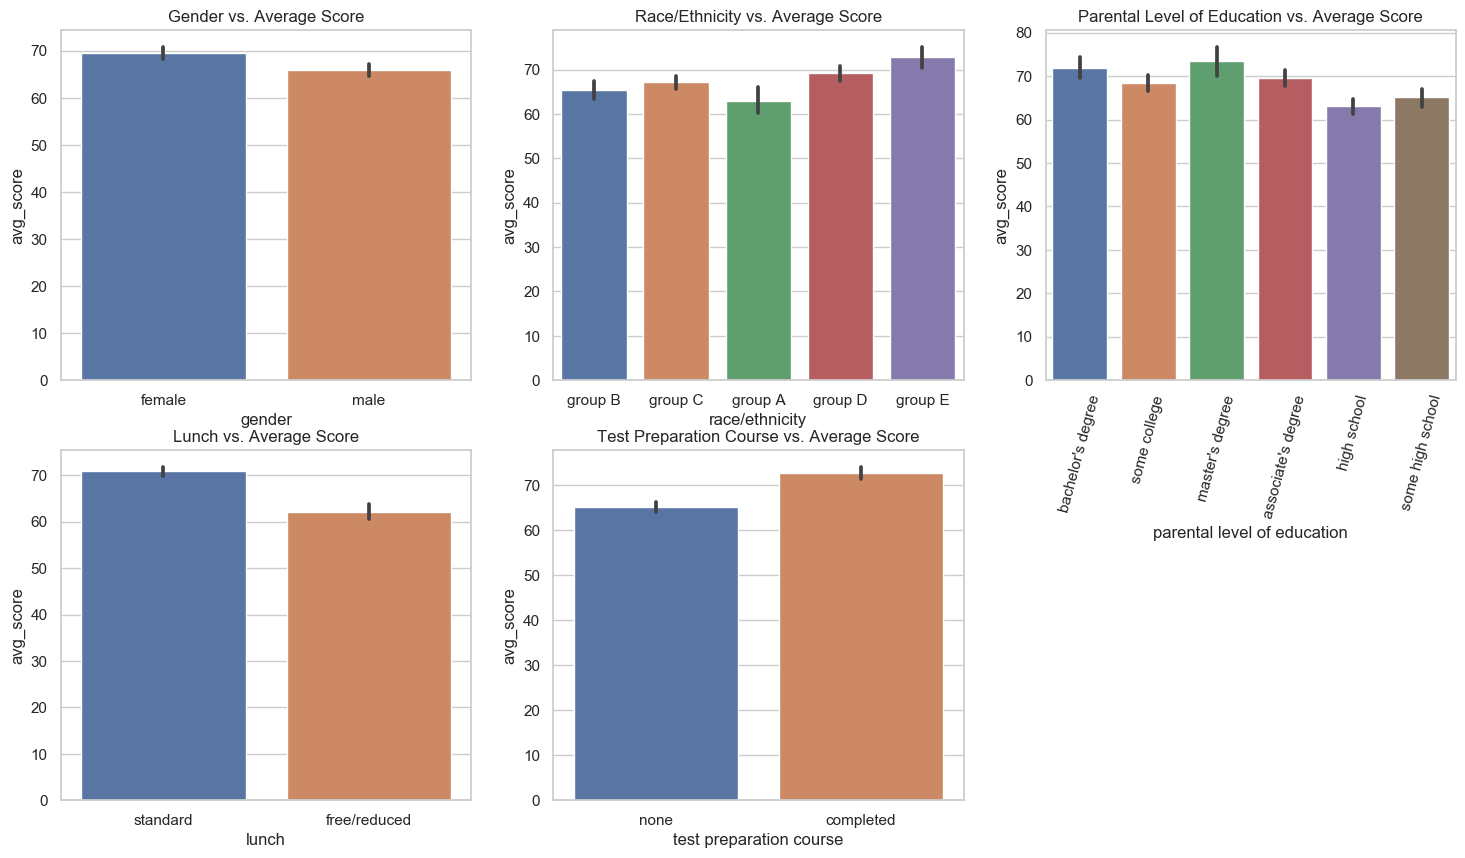

In [189]:
plt.figure(figsize=(18,10))

plt.subplot(2,3,1)
sns.barplot(student_df["gender"], student_df["avg_score"])
plt.title("Gender vs. Average Score")

plt.subplot(2,3,2)
sns.barplot(student_df["race/ethnicity"], student_df["avg_score"])
plt.title("Race/Ethnicity vs. Average Score")

plt.subplot(2,3,3)
sns.barplot(student_df["parental level of education"], student_df["avg_score"])
plt.title("Parental Level of Education vs. Average Score")
plt.xticks(rotation=75)

plt.subplot(2,3,4)
sns.barplot(student_df["lunch"], student_df["avg_score"])
plt.title("Lunch vs. Average Score")

plt.subplot(2,3,5)
sns.barplot(student_df["test preparation course"], student_df["avg_score"])
plt.title("Test Preparation Course vs. Average Score")

plt.show();

In [207]:
"""
    This is a bivariate analysis of five categorical values: gender, race/ethnicity, parental level of education, lunch, and test preparation course vs. the avg_score derrived variable
"""
# Function to perform a bivariate analysis of categorical data
def run_bivariate_test(criteria, data_frame, data_cols):
    cats = data_frame[criteria].unique()
    cat_df = data_frame.groupby(criteria)

    for col in data_cols:
        print("-"*(len(max(data_cols, key=len))+100))
        print(f"Comparisons for variable {col}")
        for i in range(0,len(cats)):
            for j in range(i+1,len(cats)):
                print(f"\t t-test between groups {cats[i]} and {cats[j]}:", end=" ")
                print(stats.ttest_ind(
                    data_frame[data_frame[criteria]==cats[i]][col], 
                    data_frame[data_frame[criteria]==cats[j]][col]
                ))
                print(" "*(len(max(data_cols, key=len))+100))
        print("="*(len(max(data_cols, key=len))+100))

In [208]:
# Perform the Bivariate analysis on the categorical columns vs. the target variable
run_bivariate_test("gender", student_df, ["avg_score"])
run_bivariate_test("race/ethnicity", student_df, ["avg_score"])
run_bivariate_test("parental level of education", student_df, ["avg_score"])
run_bivariate_test("lunch", student_df, ["avg_score"])
run_bivariate_test("test preparation course", student_df, ["avg_score"])

-------------------------------------------------------------------------------------------------------------
Comparisons for variable avg_score
	 t-test between groups female and male: Ttest_indResult(statistic=4.169913529142, pvalue=3.311973638243664e-05)
                                                                                                             
-------------------------------------------------------------------------------------------------------------
Comparisons for variable avg_score
	 t-test between groups group B and group C: Ttest_indResult(statistic=-1.2782467415831538, pvalue=0.20174731227733955)
                                                                                                             
	 t-test between groups group B and group A: Ttest_indResult(statistic=1.3165043669633527, pvalue=0.1890930589509443)
                                                                                                             
	 t-test between groups group

#### _Hypothesis testing:_
Null Hypothesis: $ H_o: \mu_f = \mu_s $ <br />
Hypothesis: $ H_a: \mu_f \neq \mu_s $ <br />
$ \alpha = 0.05 $ <br />

A p-value < the signifigance level ($ \alpha = 0.05 $) $ \therefore $ you can reject the null hypothesis which suggests the alternative.  A p-value > $ \alpha \therefore $ you fail to reject the null hypothesis  and would not have suficient evidence to conclude the alternative.

All of the categorical values have a p-value > $ \alpha $ suggesting that there is not a direct relationship between the category and average test score.